In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from matplotlib.colors import LinearSegmentedColormap
zissou = LinearSegmentedColormap.from_list("zissou", ['#1b346c','#01abe9','#f1f8f1','#f54b1a'])
from matplotlib.cm import register_cmap
register_cmap(name="zissou",cmap=zissou)
plt.style.use("rotskoff")

/home/grant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  


In [2]:
grid_pts = 3
dim = 2

sigma = 0.1
mus = torch.zeros(3**2, 2)
icov = torch.tensor([[1/sigma,0.],[0.,1/sigma]])

i=0
for m1 in torch.linspace(-1,1,grid_pts):
    j=0
    for m2 in torch.linspace(-1,1,grid_pts):
        mus[i*grid_pts+j,0] = m1
        mus[i*grid_pts+j,1] = m2
        j+=1
    i+=1

def gaussian(x,mu,icov):
    return torch.exp(-0.5 * torch.sum((x-mu) * torch.matmul((x-mu), icov), dim=2)) / (2*np.pi*sigma**2)

def mog(x,mus,icov):
    return torch.mean(gaussian(x,mus,icov),dim=1)

def mog_3x3(x):
    return mog(x,mus,icov)

In [3]:
def plot_pytorch_function(fn, figax=None, filled=False, levels=10):
    
    xs = torch.linspace(-2.,2.,100)
    ys = torch.linspace(-2.,2.,100)
    Xs,Ys = torch.meshgrid(xs,ys)
    
    with torch.no_grad():
        Zs = torch.zeros(Xs.shape)
        for i in range(len(Xs)):
            for j in range(len(Xs[i])):
                Zs[i,j] = fn(torch.tensor([Xs[i,j],Ys[i,j]], dtype=torch.float).reshape([1,1,2]))
    
    plot_data = Xs.numpy(), Ys.numpy(), Zs.numpy()

    if figax is None:
        fig, ax = plt.subplots(figsize=(6,4))
    else:
        fig, ax = figax
    ax.set_ylim(-1.5,1.5)
    ax.set_xlim(-1.5,1.5)
    if filled:
        plot = ax.contourf(*plot_data,cmap="zissou",levels=levels)
    else:
        plot = ax.contour(*plot_data,cmap="zissou",levels=levels)
    fig.tight_layout()
    fig.colorbar(plot)
    
    return fig, ax

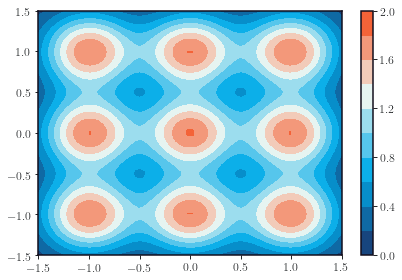

In [4]:
fig,ax = plot_pytorch_function(mog_3x3, filled=True)

In [5]:
class Discriminator(torch.nn.Module):
    def __init__(self, d_in, n, unit=torch.relu, lifted=False):
        super(Discriminator,self).__init__()
        self.n = n
        self.d_in = d_in
        self.lin1 = nn.Linear(d_in, n, bias=True)
        self.unit = unit
        self.lin2 = nn.Linear(n, 1, bias=True)

        #self.cs = nn.Parameter(torch.zeros(n,1))
#         if lifted:
#             self.ws = nn.Parameter(torch.ones(n,1)) / n
#         else:
#             self.ws = 1.
    
        
    def forward(self, x):
        x = self.lin1(x)
        x = self.unit(x)
        return self.lin2(x)
        #return torch.matmul(x,self.ws*self.cs)
        
    def clip(self):
        for param in self.parameters():
            param.data = param.data.clamp(-1e-2,1e-2)
            
    def compute_gp(self, x, lmbda=5., pad=1e-12):
        grad_vals = torch.zeros(x.shape[0],1)
        x.requires_grad=True
        torch.autograd.grad(outputs=self.forward(x), inputs=x, grad_outputs=grad_vals, create_graph=True, retain_graph=True)
        #print(grad_vals)
        grad_norm = torch.sqrt(torch.sum(grad_vals**2,dim=1)+pad).reshape(x.shape[0])
        return lmbda * torch.mean((grad_norm-1)**2)
 
    def normalize_weights(self):
        self.ws /= torch.sum(self.ws)
      
    
class Generator(torch.nn.Module):
    def __init__(self, d_in, n, d_out, unit=torch.relu, lifted=True):
        super(Generator,self).__init__()
        self.n = n
        self.d_in = d_in
        self.d_out = d_out
        self.lin1 = nn.Linear(d_in, n, bias=True)
        self.lin2 = nn.Linear(n, d_out, bias=True)
        self.unit = unit
        self.cs = nn.Parameter(torch.zeros(n,2))
        if lifted:
            self.ws = nn.Parameter(torch.ones(n,1)) / n
        else:
            self.ws = 1.
        #self.initialize(mode=init_mode)
        
#     def initialize(self, mode="meanfield"):
#         if mode == "meanfield":
#             self.lin2.weight.data = torch.randn(self.lin2.weight.data.shape)/self.n
#             #self.renormalize()
        
    def forward(self, x):
        x = self.lin1(x)
        x = self.unit(x)
        #return torch.matmul(x, self.ws*self.cs)
        return self.lin2(x)

    def normalize_weights(self):
        self.ws /= torch.sum(self.ws)
        

In [6]:
d = Discriminator(2, 128, lifted=False)
g = Generator(2, 128, 2, lifted=False)

In [7]:
g_optim = torch.optim.Adam(g.parameters(), lr=1e-4, betas=(0.5, 0.9))
d_optim = torch.optim.Adam(d.parameters(), lr=1e-4, betas=(0.5, 0.9))

n_critic = 5

In [8]:
n_data = 100*grid_pts**2
data = torch.zeros(n_data,2)
for i in range(n_data):
    data[i,:] = torch.normal(mean=mus[np.random.randint(0,grid_pts**2)], std=sigma**2*torch.ones(1,2))

In [16]:
# n_data = 100*grid_pts**2
# data = torch.zeros(n_data,2)
# for i in range(n_data):
#     data[i,:] = torch.normal(mean=mus[np.random.randint(0,grid_pts**2)], std=sigma**2*torch.ones(1,2))

n_epoch = 500
batch_size = 256
n_batch = n_data // batch_size

print(n_epoch, n_batch, batch_size)

def toggle_grad(net, enabled=True):
    for param in net.parameters():
        param.requires_grad = enabled

for epoch in range(n_epoch):
    for batch in range(n_batch):
        idx = batch*batch_size
        mini_batch = data[idx:idx+batch_size, :]
        
        
        # discriminator updates
        toggle_grad(d, enabled=True)
        toggle_grad(g, enabled=False)

        
        d_loss = 0.
        d_optim.zero_grad()
        for step in range(n_critic):
            z = torch.randn(batch_size, g.d_in)
            with torch.no_grad():
                generator_out = g(z)
                epsilon = np.random.rand()
            mini_batch_mixture = epsilon*mini_batch + (1-epsilon)*generator_out
            gradient_penalty = d.compute_gp(mini_batch_mixture)
            d_loss_step = - (torch.mean(d(mini_batch)) - torch.mean(d(generator_out)) + gradient_penalty)
            d_loss += d_loss_step
        d_loss /= n_critic
        d_loss.backward()
        d_optim.step()

        
        # generator updates
        toggle_grad(d, enabled=False)
        toggle_grad(g, enabled=True)
        g_optim.zero_grad()
        z = torch.randn(batch_size, g.d_in)
        g_loss = -torch.mean(d(g(z)))
        g_loss.backward()
        g_optim.step()
        #g.renormalize()
        #g_loss = generator_step(batch_size, g, d, g_optim)
        
    print(epoch, d_loss.item(), g_loss.item(), end="\r")
    
#     if epoch%50==0:
        
#         with torch.no_grad():
            
#             ax[fig_row,0].plot(xs,mog(xs,mus,sigma), label="target")
#             zs = torch.randn(int(10e5),g.d_in)
#             gs = g(zs)
#             ns, bins = np.histogram(gs, bins=100)
#             ax[fig_row,0].plot(bins[:-1]+0.5*(bins[1:]-bins[:-1]),ns/np.sum(ns)/(bins[1]-bins[0]), label="gen data")
#             ax[fig_row,0].legend()

#             ax[fig_row,1].plot(xs,d(xs.reshape(xs.shape[0],1)), label="discrim")
#             ax[fig_row,2].plot(xs,g(xs.reshape(xs.shape[0],1)), label="gen")

#             fig_row += 1
            
#             plt.show()
            
            

#fig.savefig("wgan_gp_lmbda={:e}_128x128.pdf".format(lmbda))

500 3 256


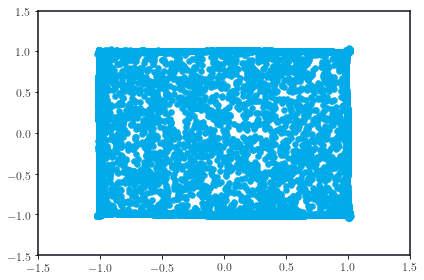

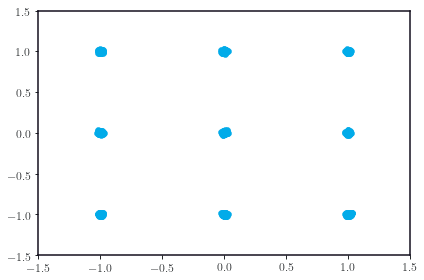

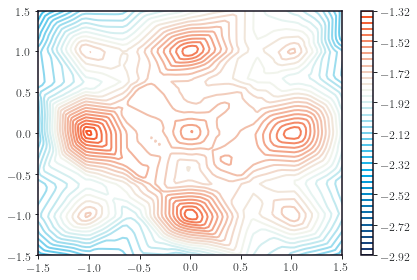

In [18]:
with torch.no_grad():
    fig, ax = plt.subplots()

    zs = torch.randn(int(10e3),g.d_in)
    gs = g(zs)

    ax.scatter(gs[:,0],gs[:,1])
    ax.set_ylim(-1.5,1.5)
    ax.set_xlim(-1.5,1.5)

    fig, ax = plt.subplots()

    ax.scatter(data[:,0],data[:,1])
    ax.set_ylim(-1.5,1.5)
    ax.set_xlim(-1.5,1.5)

    fig, ax = plot_pytorch_function(d, levels=50)

In [316]:
class Discriminator(torch.nn.Module):
    def __init__(self, d_in, n, unit=torch.relu, lifted=False):
        super(Discriminator,self).__init__()
        self.n = n
        self.d_in = d_in
        self.lin1 = nn.Linear(d_in, n, bias=True)
        self.unit = unit
        self.lin2 = nn.Linear(n, 1, bias=True)
        self.register_parameter("cs",nn.Parameter(torch.zeros(n,1)))
        self.register_parameter("prox_ws", nn.Parameter(torch.ones(n,1) / n))
    
        
    def forward(self, x):
        x = self.lin1(x)
        x = self.unit(x)
        return self.lin2(x)
        #return torch.matmul(x,self.prox_ws*self.cs)
        
    def clip(self):
        for param in self.parameters():
            param.data = param.data.clamp(-1e-2,1e-2)
            
    def compute_gp(self, x, lmbda=10., pad=1e-12):
        grad_vals = torch.zeros(x.shape[0],1)
        x.requires_grad=True
        torch.autograd.grad(outputs=self.forward(x), inputs=x, grad_outputs=grad_vals, create_graph=True, retain_graph=True)
        #print(grad_vals)
        grad_norm = torch.sqrt(torch.sum(grad_vals**2,dim=1)+pad).reshape(x.shape[0])
        return lmbda * torch.mean((grad_norm-1)**2)
 
    def normalize_weights(self):
        self.prox_ws /= torch.sum(self.prox_ws)
      
    
class Generator(nn.Module):
    def __init__(self, d_in, n, d_out, unit=torch.relu, lifted=False):
        super(Generator,self).__init__()
        self.n = n
        self.d_in = d_in
        self.d_out = d_out
        self.lin1 = nn.Linear(d_in, n, bias=True)
        #self.lin2 = nn.Linear(n, d_out, bias=True)
        self.unit = unit

        self.register_parameter("cs",nn.Parameter(np.sqrt(n)*torch.randn(n,d_out)))
        self.register_parameter("prox_ws", nn.Parameter(torch.ones(n,1) / n))
        
        
    def forward(self, x):
        x = self.lin1(x)
        x = self.unit(x)
        return torch.matmul(x, self.prox_ws*self.cs)


    def normalize_weights(self):
        self.prox_ws /= torch.sum(self.prox_ws)
        

In [317]:
# training with the proximal weight update step
def proximal_update(net, grad_w_loss, lr):
    with torch.no_grad():
        #gV = net.gradV(xs)
        expfac = net.prox_ws * torch.exp(-lr*grad_w_loss)
        net.prox_ws = nn.Parameter((expfac / torch.sum(expfac)).reshape(net.n,1))
        net.normalize_weights()

In [318]:
for name, param in gl.named_parameters():
    print(name)

cs
prox_ws
lin1.weight
lin1.bias


In [319]:
dl = Discriminator(2, 128)
gl = Generator(2, 128, 2)

dl_param_list = [p for (n,p) in dl.named_parameters() if n is not "prox_ws"]
gl_param_list = [p for (n,p) in gl.named_parameters() if n is not "prox_ws"]

# include all parameters except the weights
gl_optim = torch.optim.Adam(gl_param_list, lr=1e-4, betas=(0.5, 0.9))
dl_optim = torch.optim.Adam(dl_param_list, lr=1e-4, betas=(0.5, 0.9))

n_critic = 5

In [320]:
n_data = 100*grid_pts**2
data = torch.zeros(n_data,2)
for i in range(n_data):
    data[i,:] = torch.normal(mean=mus[np.random.randint(0,grid_pts**2)], std=sigma**2*torch.ones(1,2))

In [346]:
n_epoch = 3000
batch_size = 256
n_batch = n_data // batch_size

print(n_epoch, n_batch, batch_size)

def toggle_grad(net, enabled=True):
    for param in net.parameters():
        param.requires_grad = enabled
        

for epoch in range(n_epoch):
    for batch in range(n_batch):
        idx = batch*batch_size
        mini_batch = data[idx:idx+batch_size, :]
        
        
        # discriminator updates
        toggle_grad(dl, enabled=True)
        toggle_grad(gl, enabled=False)

        
        dl_loss = 0.
        dl.zero_grad()
        for step in range(n_critic):
            z = torch.randn(batch_size, gl.d_in)
            with torch.no_grad():
                generator_out = gl(z)
                epsilon = np.random.rand()
            mini_batch_mixture = epsilon*mini_batch + (1-epsilon)*generator_out
            gradient_penalty = dl.compute_gp(mini_batch_mixture)
            dl_loss_step = - (torch.mean(dl(mini_batch)) - torch.mean(dl(generator_out)) + gradient_penalty)
            dl_loss += dl_loss_step
        dl_loss /= n_critic
        dl_loss.backward()
        dl_optim.step()
        
        #proximal_update(dl, dl.prox_ws.grad, 1e-2)

        
        # generator updates
        toggle_grad(dl, enabled=False)
        toggle_grad(gl, enabled=True)
        gl.zero_grad()
        z = torch.randn(batch_size, gl.d_in, requires_grad=True)
        gl_loss = -torch.mean(dl(gl(z)))
        gl_loss.backward()
        gl_optim.step()
        #g.renormalize()
        #g_loss = generator_step(batch_size, g, d, g_optim)
        #proximal_update(gl, zs, 1e-2)
        proximal_update(gl, gl.prox_ws.grad, 1e-3)

        
    print(epoch, dl_loss.item(), gl_loss.item(), end="\r")
    

3000 3 256


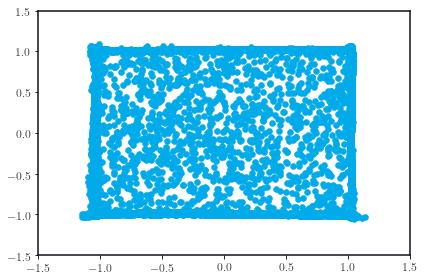

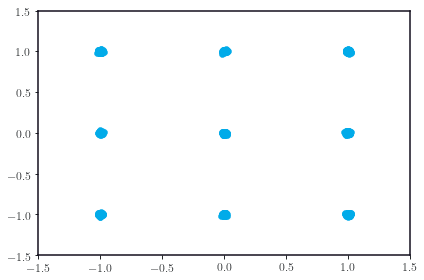

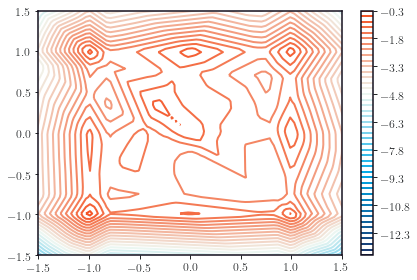

In [345]:
with torch.no_grad():
    fig, ax = plt.subplots()

    zs = torch.randn(int(10e3),gl.d_in)
    gs = gl(zs)

    ax.scatter(gs[:,0],gs[:,1])
    ax.set_ylim(-1.5,1.5)
    ax.set_xlim(-1.5,1.5)

    fig, ax = plt.subplots()

    ax.scatter(data[:,0],data[:,1])
    ax.set_ylim(-1.5,1.5)
    ax.set_xlim(-1.5,1.5)

    fig, ax = plot_pytorch_function(dl, levels=50)

In [301]:
gl.prox_ws

Parameter containing:
tensor([[0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
        [0.0078],
      